In [7]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import pickle
import umap

# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.12.1+cu102
Using device: cuda:0


In [8]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

def load_scd_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    scds = data['scd']  # (neurons, num_cov, steps)
    cov = data['covariates']  # (num_cov, steps)
    
    return scds, cov

# label brain regions
region_names = ['ANT', 'PoS', 'CA1', 'mPFC']

def plot_TI_rate_vs_ff(features_rates, features_FF, labels, label_names, cov='hd', title=None, ax=None, colors=None, s=6, legendsize=6):
    
    covariates = ['hd', 'omega', 'speed', 'x', 'y', 'time']
    
    sorted_indices = np.argsort(labels)
    sorted_rates = features_rates[sorted_indices]
    sorted_FF = features_FF[sorted_indices]
    
    num_neurons_per_region = []
    for i, name in enumerate(label_names):
        num_neurons_per_region.append(np.where(labels==i)[0].size)
    cum_neurons = np.cumsum(np.array(num_neurons_per_region))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    
    # define the colormap
    if colors is None:
        colors = list(matplotlib.colors.BASE_COLORS)
    
    if ax is None:
        _, ax = plt.subplots()
    for i, label in enumerate(label_names):
        ax.scatter(sorted_rates[cum_neurons[i]:cum_neurons[i+1], covariates.index(cov)], sorted_FF[cum_neurons[i]:cum_neurons[i+1], covariates.index(cov)], c=colors[i], label=label, alpha=0.5, s=s)
    ax.set_xlabel('TI rates')
    #ax.set_ylabel('TI Fano Factor')
    #ax.legend(prop={'size': legendsize}, loc='upper right')
    
    if title is not None:
        ax.set_title(title)

def plot_pca(components, labels, label_names, plot3d=False, ax=None, colors=None, s=6, legendsize=6):
    
    sorted_indices = np.argsort(labels)
    sorted_components = components[sorted_indices]
    
    num_neurons_per_label = []
    for i, name in enumerate(label_names):
        num_neurons_per_label.append(np.where(labels==i)[0].size)
    cum_neurons = np.cumsum(np.array(num_neurons_per_label))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    if colors is None:
        colors = list(matplotlib.colors.BASE_COLORS)

    if ax is None:
        if plot3d:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
        else:
            _, ax = plt.subplots()
    if not plot3d:
        for i, label in enumerate(label_names):
                ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=label, s=s,  alpha=0.5)
        ax.set_title('First 2 principal components of neuronal features')
    else:
        for i, label in enumerate(label_names):
                ax.scatter(sorted_components[cum_neurons[i]:cum_neurons[i+1], 0], sorted_components[cum_neurons[i]:cum_neurons[i+1], 1], sorted_components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=label, s=s,  alpha=0.5)
        ax.set_title('First 3 principal components of neuronal features')
    #ax.legend(prop={'size': legendsize}, loc='upper right')
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    if plot3d:
        ax.set_zlabel('3rd PC')

In [11]:
tc_datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'
datadir = data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

phase='wake'
bin_size=160
single_spikes=False

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, 6))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, 6))

labels_brain_regions = np.empty(0)

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        dataset = HDC.get_dataset(mouse_id, session_id, phase, 'hdc', bin_size, single_spikes, path=data_dir)
        neuron_regions = dataset['metainfo']['neuron_regions']
        labels_brain_regions = np.concatenate((labels_brain_regions, neuron_regions))
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)
            ti_rates = tuning_index(tc_rates)  # (neurons, num_cov)
            ti_FF = tuning_index(tc_FF)
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = ti_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = ti_rates.shape[0]
                
            features_rates = np.concatenate((features_rates, ti_rates), axis=0)
            features_FF = np.concatenate((features_FF, ti_FF), axis=0)

print(features_rates.shape)

labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)
print(filter_hdc.shape)

units:  85  hdc units:  22
units:  21  hdc units:  2
units:  46  hdc units:  7
units:  50  hdc units:  7
units:  55  hdc units:  5
units:  59  hdc units:  7
units:  11  hdc units:  2
units:  13  hdc units:  4
units:  17  hdc units:  4
units:  22  hdc units:  6
units:  28  hdc units:  5
units:  40  hdc units:  11
units:  43  hdc units:  11
units:  36  hdc units:  10
units:  32  hdc units:  5
units:  33  hdc units:  11
units:  56  hdc units:  14
(647, 6)
(647,)


In [12]:
import numba

@numba.njit()
def hellinger(x, y):
    result = 0.0
    l1_norm_x = 0.0
    l1_norm_y = 0.0

    for i in range(x.shape[0]):
        result += np.sqrt(x[i] * y[i])
        l1_norm_x += x[i]
        l1_norm_y += y[i]
        
    else:
        return np.sqrt(1 - result / np.sqrt(l1_norm_x * l1_norm_y))
    
@numba.njit()
def correlation_hellinger(x, y, steps, K):
    x = np.reshape(x, (steps, K))
    y = np.reshape(y, (steps, K))
    result = 0
    for i in range(x.shape[0]):
        result += hellinger(x[i], y[i])
    
    return result

In [14]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/scd_data/'
regions_datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

phase='wake'
bin_size=160
single_spikes=False

mice_sessions = {
    'Mouse12': ['120806'],#, '120807'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

# find shape of data
mouse_id = 'Mouse12'
session_id = '120806'
subset='hdc'
data, _ = load_scd_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
count = data.shape[2]
steps = data.shape[1]
num_neurons = data.shape[0]

num_hdc = {}
num_nonhdc = {}
features = np.empty((0, steps, count))  # we have 6 covariates, so 6 features
labels_brain_regions = np.empty(0)
for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        dataset = HDC.get_dataset(mouse_id, session_id, phase, 'hdc', bin_size, single_spikes, path=regions_datadir)
        neuron_regions = dataset['metainfo']['neuron_regions']
        labels_brain_regions = np.concatenate((labels_brain_regions, neuron_regions))
        for subset in ['hdc', 'nonhdc']:
            scds, covariates = load_scd_data(datadir, mouse_id, session_id, subset)

            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = scds.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = scds.shape[0]
            
            # need to pad the distributions with 0 since they don't have the same max spike count
            diff = np.abs(features.shape[2] - scds.shape[2])
            if features.shape[2] < scds.shape[2]:
                features = np.pad(features, ((0,0),(0,0),(0,diff)), mode='constant', constant_values=0)
            else:
                scds = np.pad(scds, ((0,0),(0,0),(0,diff)), mode='constant', constant_values=0)
            features = np.concatenate((features, scds), axis=0)    

K = features.shape[2]
steps = features.shape[1]
neurons = features.shape[0]

features = np.reshape(features, (neurons, steps*K))

units:  85  hdc units:  22
units:  21  hdc units:  2
units:  46  hdc units:  7
units:  50  hdc units:  7
units:  55  hdc units:  5
units:  59  hdc units:  7
units:  11  hdc units:  2
units:  13  hdc units:  4
units:  17  hdc units:  4
units:  22  hdc units:  6
units:  28  hdc units:  5
units:  40  hdc units:  11
units:  43  hdc units:  11
units:  36  hdc units:  10
units:  32  hdc units:  5
units:  33  hdc units:  11
units:  56  hdc units:  14


In [15]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

# find shape of data
mouse_id = 'Mouse12'
session_id = '120806'
subset='hdc'
data, _, _ = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
steps = data.shape[2]
num_neurons = data.shape[0]

num_hdc = {}
num_nonhdc = {}
features_rates_tc = np.empty((0, steps))  # we have 6 covariates, so 6 features
features_FF_tc = np.empty((0, steps))

correlation = []

for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
            
            features_rates_tc = np.concatenate((features_rates_tc, tc_rates[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
            features_FF_tc = np.concatenate((features_FF_tc, tc_FF[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)


In [16]:
def cm_to_inch(value):
    return value/2.54

In [31]:
mice_names = list(mice_sessions.keys())
for i, name in enumerate(mice_names):
    ind = name.rfind('e')
    new_name = name[:ind+1] + ' #' + name[ind+1:] 
    mice_names[i] = new_name
    
print(mice_names)

['Mouse #12', 'Mouse #17', 'Mouse #20', 'Mouse #24', 'Mouse #25', 'Mouse #28']


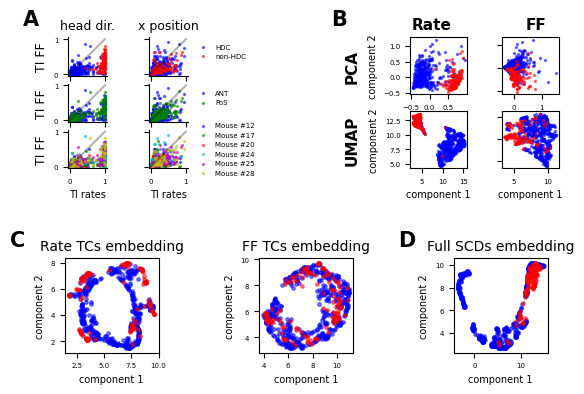

In [43]:
fig = plt.figure(figsize=(cm_to_inch(17),cm_to_inch(10.4)))
fig.text(0.09, 0.91, 'A', transform=fig.transFigure, size=15, fontweight='bold')
fig.text(0.55, 0.91, 'B', transform=fig.transFigure, size=15, fontweight='bold')
fig.text(0.07, 0.37, 'C', transform=fig.transFigure, size=15, fontweight='bold')
fig.text(0.65, 0.37, 'D', transform=fig.transFigure, size=15, fontweight='bold')


s=2  # size of dots on figures
fontsize=9  # title fontsize
legendsize=5
plt.rc('xtick', labelsize=fontsize-4) 
plt.rc('ytick', labelsize=fontsize-4) 
plt.rc('axes', labelsize=fontsize-2)

spec = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1,0.72], hspace=.8)

# manual analysis of hand-picked features

spec1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[0], wspace=1.2)

gs = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=spec1[0], hspace=.2, wspace=0, height_ratios=[1,1,1], width_ratios=[1,1])

ax = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
titles = ['head dir.', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].set_box_aspect(1)
    ax[i].plot([0,1], [0,1], color='black', alpha=0.3)
    plot_TI_rate_vs_ff(features_rates, features_FF, np.array(labels_hdc), ['HDC', 'non-HDC'], cov, f'{titles[i]}', ax[i], colors=['b', 'r'], s=s)
    if i==0:
        ax[i].set_ylabel('TI FF', size=fontsize)
        ax[i].set_yticks(ticks=[0, 1])
    else:
        ax[i].legend(prop={'size': legendsize}, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_xlabel('')
    ax[i].title.set_size(fontsize)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    

ax = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]
titles = ['head direction', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].set_box_aspect(1)
    ax[i].plot([0,1], [0,1], color='black', alpha=0.3)
    plot_TI_rate_vs_ff(features_rates, features_FF, labels_brain_regions, ['ANT', 'PoS'], cov, '', ax[i], s=s)
    if i==0:
        ax[i].set_ylabel('TI FF', size=fontsize)
        ax[i].set_yticks(ticks=[0, 1])
    else:
        ax[i].legend(prop={'size': legendsize}, loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
        ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].set_xlabel('')
    ax[i].set_title('')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)



ax = [fig.add_subplot(gs[2,0]), fig.add_subplot(gs[2,1])]
titles = ['head direction', 'x position']
for i, cov in enumerate(['hd', 'x']):
    ax[i].set_box_aspect(1)
    ax[i].plot([0,1], [0,1], color='black', alpha=0.3)
    plot_TI_rate_vs_ff(features_rates, features_FF, np.array(labels_mice), mice_names, cov, '', ax[i], s=s)
    if i==0:
        ax[i].set_ylabel('TI FF', size=fontsize)
        ax[i].set_yticks(ticks=[0, 1])

    else:
        ax[i].legend(prop={'size': legendsize}, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
        ax[i].set_yticklabels([])
    ax[i].set_title('')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)



# PCA and UMAP on hand-picked features    

fig.text(0.57, 0.81, 'PCA', rotation=90, va='center', size=11, fontweight='bold')
fig.text(0.57, 0.63, 'UMAP', rotation=90, va='center', size=11, fontweight='bold')
fig.text(0.67, 0.9, 'Rate', size=11, fontweight='bold')
fig.text(0.84, 0.9, 'FF', size=11, fontweight='bold')

pca = PCA()
pca.fit(features_rates)
components_rates = pca.transform(features_rates)
pca.fit(features_FF)
components_FF = pca.transform(features_FF)


widths=heights=[1,1]
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=spec1[1],
                                        wspace=0.3, hspace=0.3, width_ratios=widths, height_ratios=heights)

ax1 = fig.add_subplot(gs00[0,0])
plot_pca(components_rates, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax1, s=s)
ax1.legend().remove()
ax1.set_xlabel('')
ax1.set_title('')
ax1.set_box_aspect(1)



ax2 = fig.add_subplot(gs00[0,1])
plot_pca(components_FF, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax2, s=s)
#ax2.legend(prop={'size': legendsize}, loc='upper right')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_yticklabels([])
ax2.set_title('')
ax2.set_box_aspect(1)



ax3 = fig.add_subplot(gs00[1,0])
reducer = umap.UMAP(n_neighbors=20)
embedding_rates = reducer.fit_transform(features_rates)
plot_pca(embedding_rates, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax3, s=s)
ax3.set_title('')
ax3.legend().remove()
ax3.set_box_aspect(1)


ax4 = fig.add_subplot(gs00[1,1])
reducer2 = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding_ff = reducer2.fit_transform(features_FF)
plot_pca(embedding_ff, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax4, s=s)
ax4.legend().remove()
ax4.set_ylabel('')
ax4.set_yticklabels([])
ax4.set_title('')
ax4.set_box_aspect(1)



## more complex umap results

gs = gridspec.GridSpecFromSubplotSpec(1,3, wspace=0.5, width_ratios=[1,1,1], subplot_spec=spec[1])


ax1 = fig.add_subplot(gs[0])
reducer = umap.UMAP(n_neighbors=20, min_dist=0.05 , n_components=3, metric='correlation')
embedding_rates = reducer.fit_transform(features_rates_tc)
plot_pca(embedding_rates, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax1, s=s+4)
ax1.set_title('Rate TCs embedding', fontsize=fontsize+1)
ax1.set_box_aspect(1)

ax2 = fig.add_subplot(gs[1])
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1 , n_components=3, metric='correlation')
embedding_ff = reducer.fit_transform(features_FF_tc)
plot_pca(embedding_ff, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax2, s=s+4)
ax2.set_title('FF TCs embedding', fontsize=fontsize+1)
ax2.set_box_aspect(1)


ax3 = fig.add_subplot(gs[2])
kwds = [steps, K]
mapping = umap.UMAP(n_neighbors=20, min_dist=0.1, n_components=3, metric=correlation_hellinger, metric_kwds={'steps':steps, 'K':K}).fit(features)
embedding = mapping.embedding_
plot_pca(embedding, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], ax=ax3, s=s+4)
ax3.set_title('Full SCDs embedding', fontsize=fontsize+1)
ax3.set_box_aspect(1)

from matplotlib import lines
x = [0.63, 0.89]
y = [0.53, 0.87]
line1 = lines.Line2D([0.762, 0.762], y, color='dimgray', transform=fig.transFigure)
line2 = lines.Line2D(x, [0.693, 0.693], color='dimgray', transform=fig.transFigure)

#fig.lines.append(line1)
#fig.lines.append(line2)



Text(0.5, 1.0, 'UMAP; Rate features')

<Figure size 300x300 with 0 Axes>

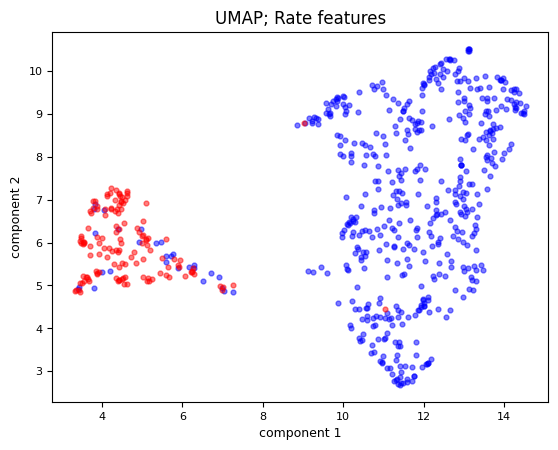

In [18]:
fig = plt.figure(figsize=(3,3))

reducer = umap.UMAP(n_neighbors=20)
embedding_rates = reducer.fit_transform(features_rates)
plot_pca(embedding_rates, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], s=12)
plt.title('UMAP; Rate features')


Text(0.5, 1.0, 'UMAP; Fano Factor features')

<Figure size 300x300 with 0 Axes>

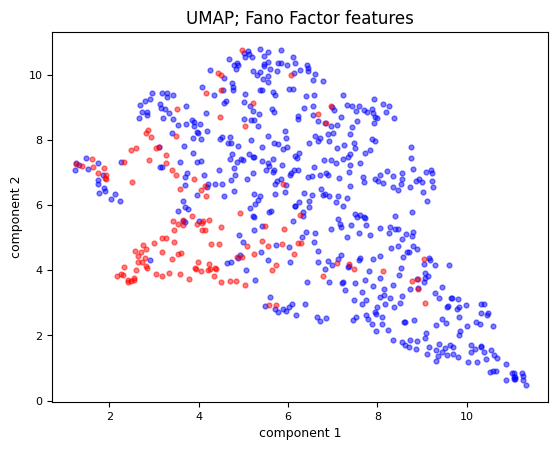

In [18]:
fig = plt.figure(figsize=(3,3))


reducer2 = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding_ff = reducer2.fit_transform(features_FF)
plot_pca(embedding_ff, np.array(labels_hdc), ['HDC', 'non-HDC'], colors=['b', 'r'], s=12)
plt.title('UMAP; Fano Factor features')

